In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [142]:
# Define a Value object to store large datatypes for calculations
class Value:

    def __init__(self, data, _children=(), _op='', label=''): # _children is an empty tuple, but we use it as a set for efficiency
        self.data = data
        self.grad = 0.0 # This is the gradient (slope) of a final Value object wrt its children or grandchildren (current node)
        self._backward = lambda: None # Empty function, used to calculate chain rule for backpropagation
        self._prev = set(_children) # This will be used for forward pass/backprop so the function knows the previous values used to reach this value
        self._op = _op # _op is the operator represented using a string, used for forward pass/backprop 
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # Treat the other as a Value object it is already is not
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float powers for now."
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)    

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self, ), 'ReLU')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
    
    # Implementing topological sort to automatically do the _backward calls for backpropagation for self and each previous node in the toposort
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

In [143]:
a = Value(2.0)
b = Value(3.0)

a - b

Value(data=-1.0, grad=0.0)

In [4]:
# Visual the Value objects as nodes in a graph
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data: %.4f | grad: %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is the result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [5]:
# Example activation of a neuron
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value (0.0, label='x2')

# Weights w1, w2
w1 = Value (-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron b
b = Value(6.8813735870195432, label='b')

w1x1 = x1*w1; w1x1.label = 'w1*x1'
w2x2 = x2*w2; w2x2.label = 'w2*x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1*x1 + w2*x2'
n = w1x1w2x2 + b; n.label = 'n'

# tanh activation
o = n.tanh(); o.label = 'o'

# Automatic backpropagation
o.backward()

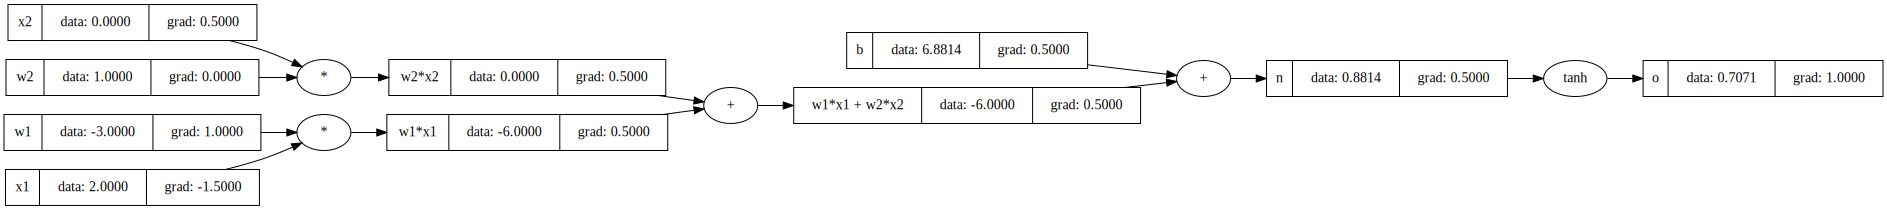

In [6]:
draw_dot(o)

In [7]:
# Example activation of a neuron
# Inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value (0.0, label='x2')

# Weights w1, w2
w1 = Value (-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron b
b = Value(6.8813735870195432, label='b')

w1x1 = x1*w1; w1x1.label = 'w1*x1'
w2x2 = x2*w2; w2x2.label = 'w2*x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1*x1 + w2*x2'
n = w1x1w2x2 + b; n.label = 'n'

# tanh activation (elementary level)
e = (2*n).exp()
o = (e - 1)/(e + 1) 

# Automatic backpropagation
o.backward()

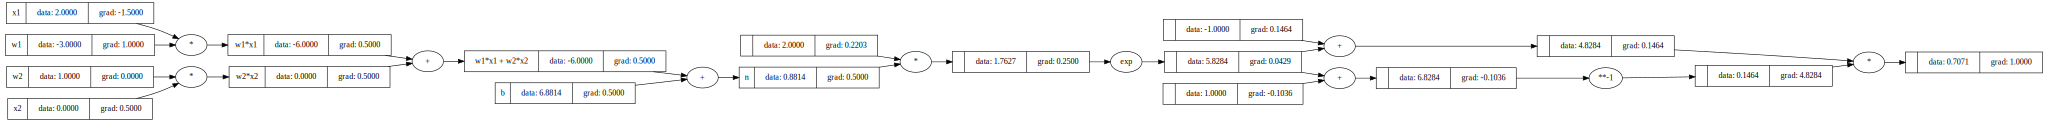

In [8]:
draw_dot(o)

In [144]:
# Define a Neuron class for neural networks
class Neuron:

    def __init__(self, nin):    # nin: number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]    # Random weights between -1 and 1
        self.b = Value(random.uniform(-1, 1))    # Random bias between -1 and 1
        

    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)  # sum(wi * xi) + b
        out = act.tanh()    # tanh(sum(wi * xi) + b)
        return out
    
    def parameters(self):
        return self.w + [self.b]

# Define a Layer class for the neurons
class Layer:

    def __init__(self, nin, nout):  # nout: number of outputs
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
    
# Define a multilayer perceptron (MLP) class
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [154]:
# Creating a tiny dataset
xs = [
    [2.0, 3.0, -1.0, 6.0],
    [3.0, -1.0, 0.5, 2.0],
    [0.5, 1.0, 1.0, -1.0],
    [1.0, 1.0, -1.0, -3.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # Desired targets

# Define the MLP Neural Network
model = MLP(4, [6, 4, 1])
print(f"Size of Network: {len(model.parameters())} Parameters")

Size of Network: 63 Parameters


In [155]:
# Foward pass
for k in range(50):
    ypred = [model(x) for x in xs]
    # Define the loss function
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0.0))   # MSE loss

    # Backward pass to set gradients
    for p in n.parameters():    # Flush the gradients to zero for backprop to prevent the gradients to accumulate (as we are doing self.grad += something in the Value object functions)
        p.grad = 0.0
    loss.backward()

    # Update the parameters using gradient descent
    for p in n.parameters():
        p.data += -0.02 * p.grad
    
    print(k, loss.data)


0 5.960111269058048
1 5.960111269058048
2 5.960111269058048
3 5.960111269058048
4 5.960111269058048
5 5.960111269058048
6 5.960111269058048
7 5.960111269058048
8 5.960111269058048
9 5.960111269058048
10 5.960111269058048
11 5.960111269058048
12 5.960111269058048
13 5.960111269058048
14 5.960111269058048
15 5.960111269058048
16 5.960111269058048
17 5.960111269058048
18 5.960111269058048
19 5.960111269058048
20 5.960111269058048
21 5.960111269058048
22 5.960111269058048
23 5.960111269058048
24 5.960111269058048
25 5.960111269058048
26 5.960111269058048
27 5.960111269058048
28 5.960111269058048
29 5.960111269058048
30 5.960111269058048
31 5.960111269058048
32 5.960111269058048
33 5.960111269058048
34 5.960111269058048
35 5.960111269058048
36 5.960111269058048
37 5.960111269058048
38 5.960111269058048
39 5.960111269058048
40 5.960111269058048
41 5.960111269058048
42 5.960111269058048
43 5.960111269058048
44 5.960111269058048
45 5.960111269058048
46 5.960111269058048
47 5.960111269058048
48

In [156]:
ypred

[Value(data=0.9839334490395595, grad=-0.032133101920881035),
 Value(data=0.5356492929039759, grad=3.071298585807952),
 Value(data=0.8970552129622013, grad=3.7941104259244023),
 Value(data=0.9469349156719731, grad=-0.10613016865605385)]